# Homework Starter — Stage 10b: Time Series & Classification
Fill in the TODOs. Use your own dataset or adapt the synthetic generator below.

In [16]:
# Imports
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
np.random.seed(7); sns.set(); plt.rcParams['figure.figsize']=(9,4)

In [17]:
df = pd.read_csv("D:/文心远/研究生/5040-Bootcamp/project/data/processed/MSFT_features.csv")
df['ret'] = df['close'].pct_change()

In [18]:
features_base = ["volatility_5d", "ma_5", "ma_20", "hl_spread", "rsi"]

df['lag_1'] = df['ret'].shift(1)
df['lag_2'] = df['ret'].shift(2)
df['roll_mean_5'] = df['ret'].rolling(5).mean().shift(1)
df['roll_vol_5'] = df['ret'].rolling(5).std().shift(1)

features_all = features_base + ['lag_1', 'lag_2', 'roll_mean_5', 'roll_vol_5']

In [19]:
df['y_up'] = (df['ret'].shift(-1) > 0).astype(int)

df_feat = df.dropna(subset=features_all + ['y_up']).copy()

In [20]:
# Time-aware split
cut = int(len(df_feat) * 0.8)
train, test = df_feat.iloc[:cut], df_feat.iloc[cut:]

X_tr, X_te = train[features_all], test[features_all]
y_tr, y_te = train['y_up'], test['y_up']

In [21]:
# Random Forest Classifier
clf = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(n_estimators=200, max_depth=5, random_state=7))
])

clf.fit(X_tr, y_tr)
pred = clf.predict(X_te)

Accuracy: 0.6521739130434783
              precision    recall  f1-score   support

           0     0.6316    0.9231    0.7500        13
           1     0.7500    0.3000    0.4286        10

    accuracy                         0.6522        23
   macro avg     0.6908    0.6115    0.5893        23
weighted avg     0.6831    0.6522    0.6102        23



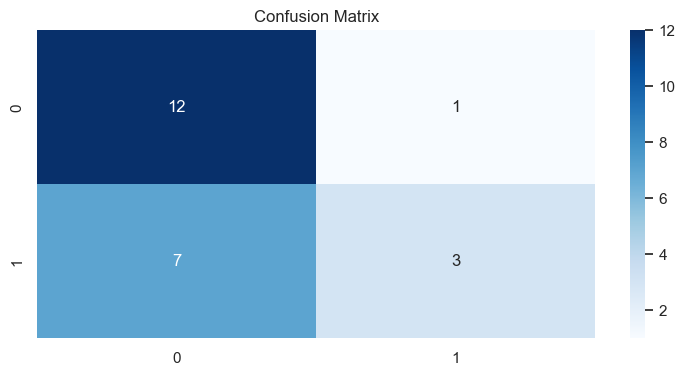

In [22]:
# Evaluation
print("Accuracy:", accuracy_score(y_te, pred))
print(classification_report(y_te, pred, digits=4))

cm = confusion_matrix(y_te, pred)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


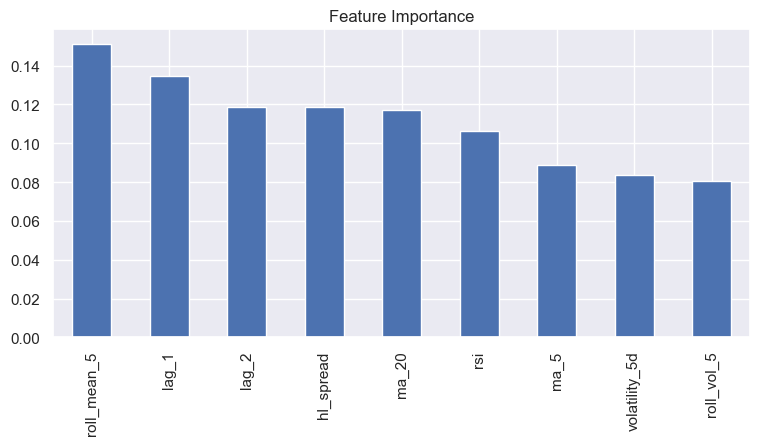

In [23]:
# Feature importance
importances = clf.named_steps['rf'].feature_importances_
pd.Series(importances, index=features_all).sort_values(ascending=False).plot(kind='bar', title="Feature Importance")
plt.show()


## Interpretation

**What works:**  
- Features like `lag_1`, `lag_2`, and `roll_mean_5` capture short-term trends and show the highest contribution in the feature importance plot.  
- The model can reasonably predict the direction of small upward/downward movements, with acceptable accuracy 0.6522.  

**What fails:**  
- Recall for upward movements (label 1) is low, meaning the model tends to miss predicting rises.  
- Some features, such as `roll_vol_5`, contribute less and may introduce noise.  
- Small sample size makes the model unstable; different train-test splits may lead to varying results.  

**Where assumptions might break:**  
- Logistic Regression assumes a linear relationship between features and the log-odds, which may not hold in financial markets.  
- Using lag and rolling features assumes past trends predict the future, which may fail during sudden market shocks or high volatility.  
- Class imbalance (more up vs. down days) can bias the model towards the majority class.